# The Render Pipeline

In [ ]:
# Ensure the repository root is first on sys.path so local modules are used
import sys, os, importlib.util
proj_root = os.path.abspath(os.getcwd())
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)
print('Inserted proj_root into sys.path:', proj_root)
spec = importlib.util.find_spec('primitives')
print('primitives spec:', spec)
try:
    from lab3.primitives import cube
    print('Imported cube from primitives, object:', getattr(cube, '__name__', cube))
except Exception as e:
    print('Import error when importing primitives.cube:', type(e).__name__, e)


Inserted proj_root into sys.path: c:\_GPU
primitives spec: ModuleSpec(name='primitives', loader=<_frozen_importlib_external.SourceFileLoader object at 0x000001D786A76390>, origin='c:\\_GPU\\.venv\\Lib\\site-packages\\primitives\\__init__.py', submodule_search_locations=['c:\\_GPU\\.venv\\Lib\\site-packages\\primitives'])
Import error when importing primitives.cube: ImportError cannot import name 'cube' from 'primitives' (c:\_GPU\.venv\Lib\site-packages\primitives\__init__.py)


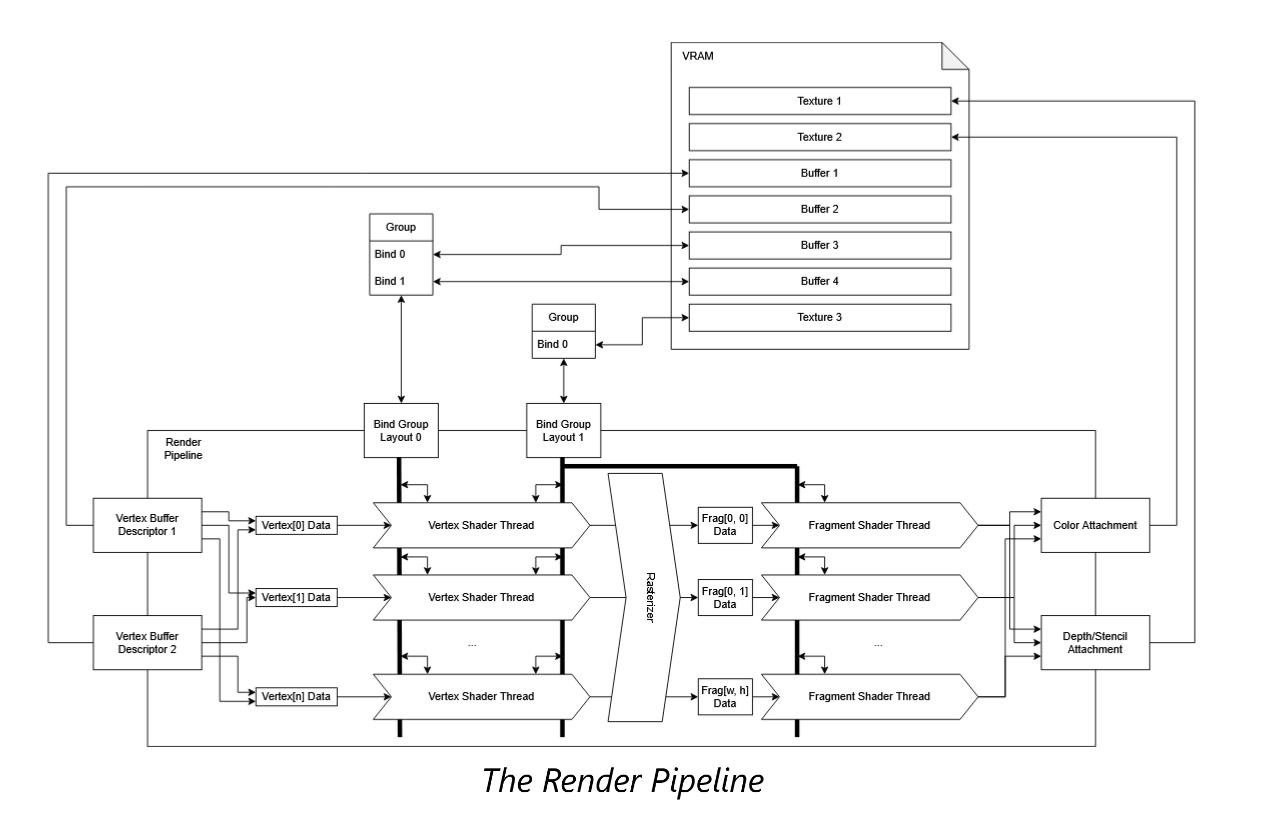

- les primitives on a :
    - les triangles 
    - il y'a plus des pièces mobiles dans un render pipeline
    - les info : dans vertex : position et l'espace
    - position, normal, color, texture coordonnées

- on utilise un sys d'indexiation pour les buffers, 


- exemple des données on utilise numpy données: 
    - pour un cube on devrait avoir 8 vertex
    - mais comme y'en a qui font la meme chose on se retrouve avec 6

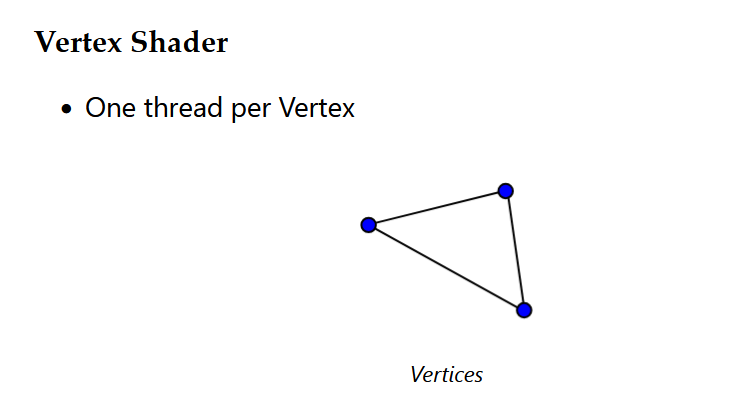

le but se de produire les CLipspace: les espaces camereas par exemple
- object space
        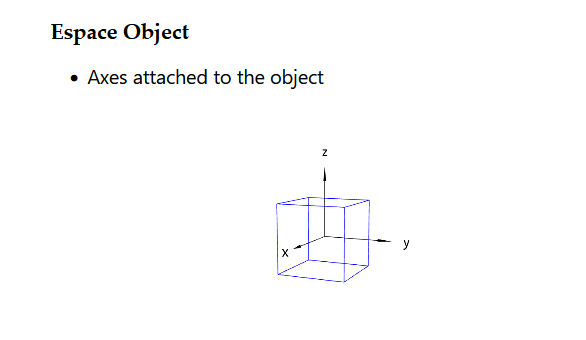

        les positions ne changent pas : cela se fait pas une transition ou multiplication matricielle.

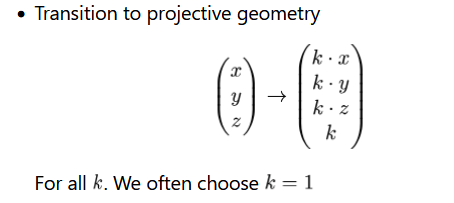


- World space

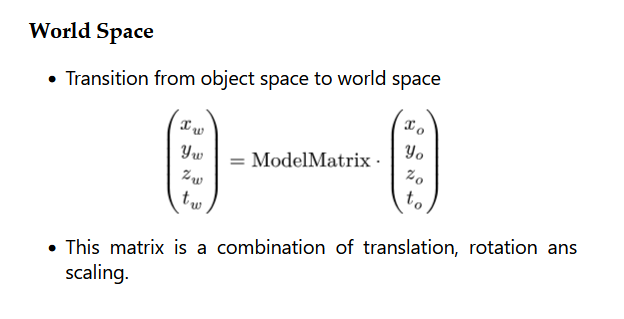

- Camera: 

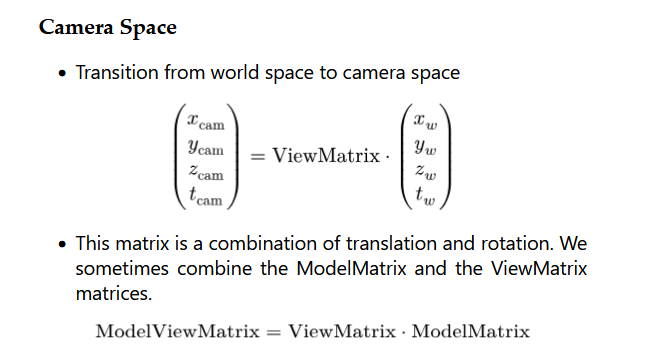

In [2]:
# on utilise une fonction look_at
import numpy as np
from numpy.typing import ArrayLike, NDArray

def look_at(
    eye: ArrayLike, target: ArrayLike, up: ArrayLike
) -> NDArray:
    """
    Convert world coordinates to camera coordinates where the camera
    point in the direction of -z axis.
    """
    eye = np.array(eye, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    up = np.array(up, dtype=np.float32)
    f = target - eye
    f = f / np.linalg.norm(f)
    s = np.cross(f, up)
    s = s / np.linalg.norm(s)
    u = np.cross(s, f)

    return np.array([[ s[0],  s[1],  s[2], -eye @ s],
                     [ u[0],  u[1],  u[2], -eye @ u],
                     [-f[0], -f[1], -f[2],  eye @ f],
                     [    0,     0,     0,        1]], dtype=np.float32)

après cela on fait une projection :

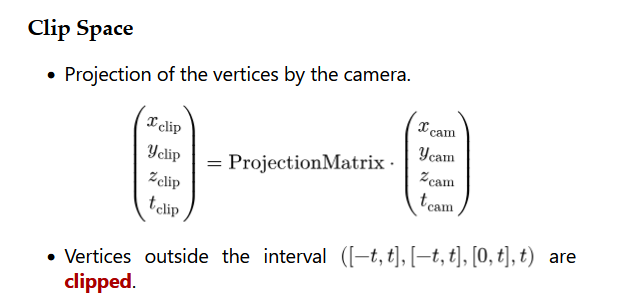

- matrice persectective
    - ici le nearm dist mini
    - et far dist max
    


In [28]:


def perspective(
    fovy_deg: float, aspect: float, near: float, far: float
) -> NDArray:
    """
    Convert camera coordinates to wgpu clip coordinates where x and y goes
    from -1.0 to 1.0 and z goes from 0.0 to 1.0.
    """

    angle = fovy_deg * np.pi / 180

    yspan = near * np.tan(angle)
    xspan = yspan * aspect

    c0r0 = 2 * near / xspan
    c1r1 = 2 * near / yspan
    c2r2 = -(far + near) / (far - near) / 2 - 0.5
    c3r2 = -far * near / (far - near)

    return np.array([[c0r0,    0,    0,    0],
                     [   0, c1r1,    0,    0],
                     [   0,    0, c2r2, c3r2],
                     [   0,    0,   -1,    0]], dtype=np.float32)

après on aura la `divistion perspective` : 

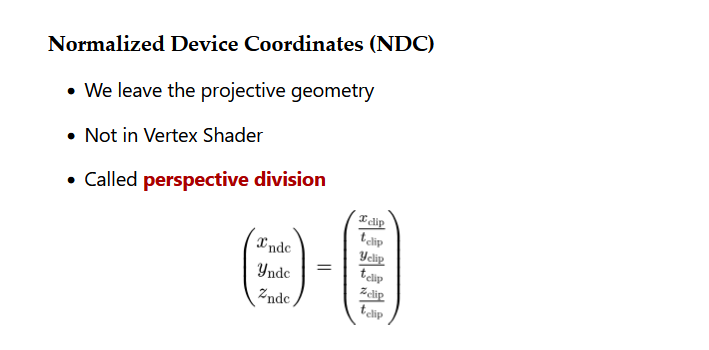

# diffrecne entre fragment et pixels 

plusieurs fragement sont affichés sur un seul pixel

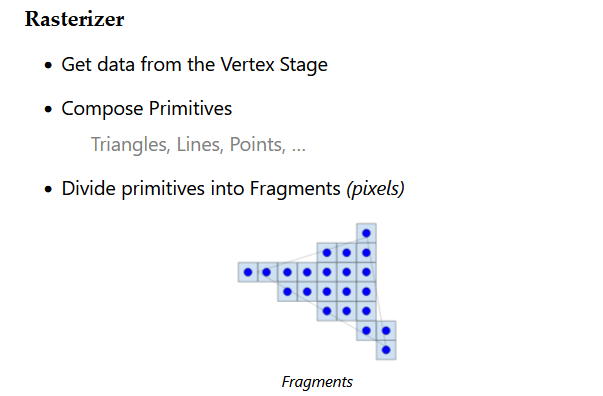

ce que fait le rasterizer, il faut normakliser pour donner la taille de 1.

le but c'est de calculer. 

on utilise une technique de buffer pour ne pas afficher une sur une autre.

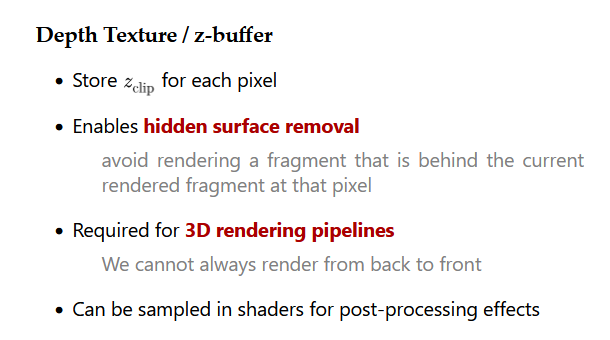

In [29]:
from rendercanvas.auto import RenderCanvas, loop
import wgpu     


adapter = wgpu.gpu.request_adapter_sync(power_preference="high-performance")
device = adapter.request_device_sync()

canvas = RenderCanvas(
    size=(640, 480), title="WebGPU Example",
    update_mode="continuous", max_fps=60,
)
context = canvas.get_wgpu_context()
render_texture_format = context.get_preferred_format(device.adapter)
context.configure(device=device, format=render_texture_format)

@canvas.request_draw
def draw_frame():
    screen_texture = context.get_current_texture()
    # render in the screen_texture


# shading

les diffuses shading, ce patch renvoi la couleur de patch, l'intensité.

- angle : 1 = color un suel
- angle : 0 = color pleine


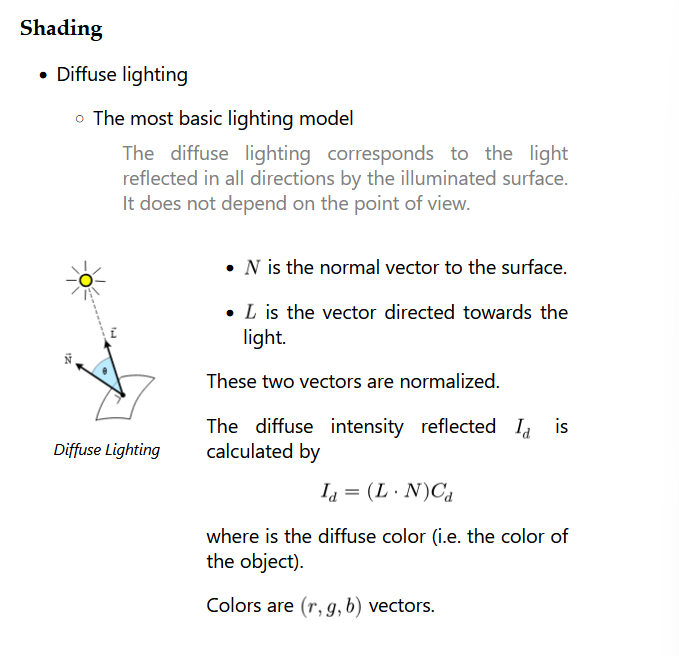


pour chaque vecteur on specifie les coord des textures, compris entre (0,1)

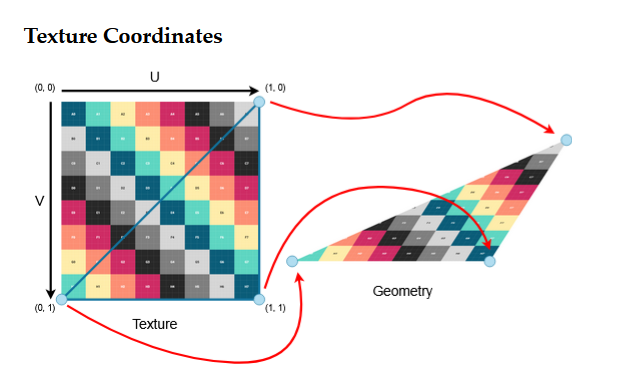






# Vertex Buffers

In [35]:
vertex_data = np.array(
    [
        #   x,    y,    z,   xn,   yn,   zn,    u,    v
        [ 0.5,  0.5,  0.5,  0.0,  0.0,  1.0,  0.0,  0.0],
        [-0.5,  0.5,  0.5,  0.0,  0.0,  1.0,  0.0,  1.0],
        [-0.5, -0.5,  0.5,  0.0,  0.0,  1.0,  1.0,  1.0],
        [ 0.5, -0.5,  0.5,  0.0,  0.0,  1.0,  1.0,  0.0],

        [ 0.5,  0.5,  0.5,  1.0,  0.0,  0.0,  0.0,  0.0],
        [ 0.5, -0.5,  0.5,  1.0,  0.0,  0.0,  0.0,  1.0],
        [ 0.5, -0.5, -0.5,  1.0,  0.0,  0.0,  1.0,  1.0],
        [ 0.5,  0.5, -0.5,  1.0,  0.0,  0.0,  1.0,  0.0],

        [ 0.5,  0.5, -0.5,  0.0,  0.0, -1.0,  0.0,  0.0],
        [ 0.5, -0.5, -0.5,  0.0,  0.0, -1.0,  0.0,  1.0],
        [-0.5, -0.5, -0.5,  0.0,  0.0, -1.0,  1.0,  1.0],
        [-0.5,  0.5, -0.5,  0.0,  0.0, -1.0,  1.0,  0.0],

        [-0.5,  0.5,  0.5, -1.0,  0.0,  0.0,  0.0,  0.0],
        [-0.5,  0.5, -0.5, -1.0,  0.0,  0.0,  0.0,  1.0],
        [-0.5, -0.5, -0.5, -1.0,  0.0,  0.0,  1.0,  1.0],
        [-0.5, -0.5,  0.5, -1.0,  0.0,  0.0,  1.0,  0.0],

        [ 0.5,  0.5,  0.5,  0.0,  1.0,  0.0,  0.0,  0.0],
        [ 0.5,  0.5, -0.5,  0.0,  1.0,  0.0,  0.0,  1.0],
        [-0.5,  0.5, -0.5,  0.0,  1.0,  0.0,  1.0,  1.0],
        [-0.5,  0.5,  0.5,  0.0,  1.0,  0.0,  1.0,  0.0],

        [ 0.5, -0.5,  0.5,  0.0, -1.0,  0.0,  0.0,  0.0],
        [-0.5, -0.5,  0.5,  0.0, -1.0,  0.0,  0.0,  1.0],
        [-0.5, -0.5, -0.5,  0.0, -1.0,  0.0,  1.0,  1.0],
        [ 0.5, -0.5, -0.5,  0.0, -1.0,  0.0,  1.0,  0.0],
    ],
    dtype=np.float32,
)

index_data = np.array(
    [
        0,  1,  2,  0,  2,  3,
        4,  5,  6,  4,  6,  7,
        8,  9, 10,  8, 10, 11,
        12, 13, 14, 12, 14, 15,
        16, 17, 18, 16, 18, 19,
        20, 21, 22, 20, 22, 23,
    ],
    dtype=np.uint32,
)

print("Vertex data size:", vertex_data.nbytes)
print("Index data size:", index_data.nbytes)

Vertex data size: 768
Index data size: 144


# view matrix

In [36]:
def look_at(
    eye: ArrayLike, target: ArrayLike, up: ArrayLike
) -> NDArray:
    """
    Convert world coordinates to camera coordinates where the camera
    point in the direction of -z axis.
    """
    eye = np.array(eye, dtype=np.float32)
    target = np.array(target, dtype=np.float32)
    up = np.array(up, dtype=np.float32)
    f = target - eye
    f = f / np.linalg.norm(f)
    s = np.cross(f, up)
    s = s / np.linalg.norm(s)
    u = np.cross(s, f)

    return np.array([[ s[0],  s[1],  s[2], -eye @ s],
                     [ u[0],  u[1],  u[2], -eye @ u],
                     [-f[0], -f[1], -f[2],  eye @ f],
                     [    0,     0,     0,        1]], dtype=np.float32)

print("look_at function defined.")  

look_at function defined.


# Projection matrix

In [37]:
def perspective(
    fovy_deg: float, aspect: float, near: float, far: float
) -> NDArray:
    
    """
    Convert camera coordinates to wgpu clip coordinates where x and y goes
    from -1.0 to 1.0 and z goes from 0.0 to 1.0.
    """

    angle = fovy_deg * np.pi / 180

    yspan = near * np.tan(angle)
    xspan = yspan * aspect

    c0r0 = 2 * near / xspan
    c1r1 = 2 * near / yspan
    c2r2 = -(far + near) / (far - near) / 2 - 0.5
    c3r2 = -far * near / (far - near)

    return np.array([[c0r0,    0,    0,    0],
                     [   0, c1r1,    0,    0],
                     [   0,    0, c2r2, c3r2],
                     [   0,    0,   -1,    0]], dtype=np.float32)

print("perspective function defined.")

perspective function defined.


# Camera

In [ ]:
import numpy as np
from numpy.typing import NDArray, ArrayLike
from lab3.cgmath import look_at, perspective


class Camera:
    def __init__(
        self,
        fovy_deg: float,
        aspect: float,
        near: float,
        far: float,
        radius: float,
        longitude: float,
        latitude: float,
        target: ArrayLike = [0.0, 0.0, 0.0],
    ):
        self.pointer_down = False
        self.last_pointer_pos = np.array([0.0, 0.0])
        self.radius = 3
        self.longitude = np.pi / 4
        self.latitude = np.pi / 4
        self.fovy_deg = fovy_deg
        self.aspect = aspect
        self.near = near
        self.far = far
        self.radius = radius
        self.longitude = longitude
        self.latitude = latitude
        self.target = np.array(target)

    def get_matrices(self) -> tuple[NDArray, NDArray]:
        camera_position = np.array(
            [
                np.cos(self.latitude) * np.cos(self.longitude),
                np.sin(self.latitude),
                np.cos(self.latitude) * np.sin(self.longitude),
            ]
        )

        camera_position = self.target + camera_position * self.radius

        view_matrix = look_at(camera_position, [0, 0, 0], [0, 1, 0])
        proj_matrix = perspective(45, self.aspect, 0.1, 100)

        return proj_matrix, view_matrix

    def process_event(self, event):
        if event["event_type"] == "pointer_down":
            self.pointer_down = True
        elif event["event_type"] == "pointer_up":
            self.pointer_down = False
        elif event["event_type"] == "pointer_move":
            pointer_pos = np.array([event["x"], event["y"]])
            delta = pointer_pos - self.last_pointer_pos
            self.last_pointer_pos = pointer_pos
            if self.pointer_down:
                self.longitude = (self.longitude + delta[0] * 0.01) % (2 * np.pi)
                self.latitude = np.clip(
                    self.latitude + delta[1] * 0.01, -np.pi / 2, np.pi / 2
                )

        elif event["event_type"] == "wheel":
            self.radius = max(0.1, self.radius + event["dy"] * 0.001)


print("Camera class defined.")


Camera class defined.


# Primitives

# Cube

In [ ]:
from rendercanvas.auto import RenderCanvas, loop
import wgpu
import numpy as np
import PIL.Image as Image
from lab3.primitives import cube
from camera import Camera


class App:
    def __init__(self):
        adapter = wgpu.gpu.request_adapter_sync(power_preference="high-performance")
        self.device = adapter.request_device_sync()

        self.size = (0, 0)

        self.canvas = RenderCanvas(
            size=(640, 480),
            title="WebGPU Example",
            update_mode="continuous",
            max_fps=60,
        )
        self.context = self.canvas.get_wgpu_context()

        render_texture_format = self.context.get_preferred_format(self.device.adapter)
        self.context.configure(device=self.device, format=render_texture_format)

        vertex_data, index_data = cube()

        self.vertex_buffer = self.device.create_buffer_with_data(
            data=vertex_data, usage=wgpu.BufferUsage.VERTEX
        )

        self.index_buffer = self.device.create_buffer_with_data(
            data=index_data, usage=wgpu.BufferUsage.INDEX
        )

        bg_layout = self.device.create_bind_group_layout(
            entries=[
                # données de la caméra et de la lumière
                {
                    "binding": 0,
                    "visibility": wgpu.ShaderStage.VERTEX | wgpu.ShaderStage.FRAGMENT,
                    "buffer": {"type": wgpu.BufferBindingType.uniform},
                },
                # texture
                {
                    "binding": 1,
                    "visibility": wgpu.ShaderStage.FRAGMENT,
                    "texture": {},
                },
                # sampler 
                {
                    "binding": 2,
                    "visibility": wgpu.ShaderStage.FRAGMENT,
                    "sampler": {},
                },
            ]
        )

        #  pipeline layout
        p_layout = self.device.create_pipeline_layout(bind_group_layouts=[bg_layout])

        # la taille est calculée comme suit :
        # vec4 light_position + mat4 view_matrix + mat4 proj_matrix
        # light_posotion est une vec4 pour l'alignement mémoire qui a 4 bits

        self.render_params_buffer = self.device.create_buffer(
            size=4 * 4 + 2 * 4 * 4 * 4,
            # unifrom on peut pas écrire partiellement dans un buffer uniform etant donné qu'on a pas trop des données qui changent souvent
            usage=wgpu.BufferUsage.UNIFORM | wgpu.BufferUsage.COPY_DST,
        )

        # ouverture et chargement de l'image de texture
        img = Image.open("./texel_checker.png")
        texture_size = img.size + (1,)
        texture = self.device.create_texture(
            size=texture_size,
            # rgba8unorm_srgb pour faire la correction gamma et srgb    
            format=wgpu.TextureFormat.rgba8unorm_srgb,
            usage=wgpu.TextureUsage.TEXTURE_BINDING | wgpu.TextureUsage.COPY_DST,
        )
        self.device.queue.write_texture(
            destination={
                "texture": texture,
            },
            # conversion de l'image en tableau numpy
            data=np.asarray(img),
            # on à 4 bytes par pixel (rgba8)
            data_layout={
                "bytes_per_row": img.size[0] * 4,
            },
            size=texture_size,
        )
        # création du sampler (c'est quoi le sampler ?)
        # si on veut une texture plus grande que l'originale on doit définir un filtre
        sampler = self.device.create_sampler()

        # création du bind group pour les paramètres de rendu

        self.render_params_bind_group = self.device.create_bind_group(
            layout=bg_layout,
            entries=[
                # données de la caméra et de la lumière
                {
                    "binding": 0,
                    "resource": {
                        "buffer": self.render_params_buffer,
                        "offset": 0,
                        "size": self.render_params_buffer.size,
                    },
                },
                {
                    "binding": 1,
                    "resource": texture.create_view(),
                },
                {
                    "binding": 2,
                    "resource": sampler,
                },
            ],
        )

        # gestion des événements pour la caméra avec la souris
        self.canvas.add_event_handler(
            self.process_event, "pointer_up", "pointer_down", "pointer_move", "wheel"
        )  # type: ignore

    # initialisation de la caméra
    # positionnée à (3,3,3) et regardant vers l'origine
    # up est l'axe y
    # fov 45 degrés, near 0.1, far 100
    # aspect sera mis à jour dans la boucle principale
    # angle de rotation initiale de la caméra
    # angle_x = pi/4, angle_y = pi/4
    # on utilise la classe Camera définie dans camera.py
        self.camera = Camera(45, 640 / 480, 0.1, 100, 3, np.pi / 4, np.pi / 4)

        vertex_buffer_descriptor = {
            "array_stride": 8 * 4, # 8 floats par sommet, 4 bytes par float
            "step_mode": wgpu.VertexStepMode.vertex, # on change de sommet à chaque itération
            "attributes": [ # description des attributs de sommet
                {
                    "format": wgpu.VertexFormat.float32x3,# position
                    "offset": 0,
                    "shader_location": 0,
                },
                {
                    "format": wgpu.VertexFormat.float32x3,# normale
                    "offset": 3 * 4,
                    "shader_location": 1,
                },
                {
                    "format": wgpu.VertexFormat.float32x2,# coordonnée de texture
                    "offset": 6 * 4,# après 6 floats
                    "shader_location": 2,# emplacement 2 dans le shader
                },
            ],
        }

        # le code du shader est dans un fichier séparé (render.wgsl)
        with open("./render.wgsl") as file:
            shader_module = self.device.create_shader_module(code=file.read())

        # création du pipeline de rendu
        self.pipeline = self.device.create_render_pipeline(
            layout=p_layout,
            vertex={ # description du shader de vertex
                "module": shader_module,
                "entry_point": "vs_main",
                "buffers": [vertex_buffer_descriptor],
            },
            primitive={# description du type de primitive
                "topology": wgpu.PrimitiveTopology.triangle_list,# triangles, 3 sommets par triangle
                "front_face": wgpu.FrontFace.ccw,# on dit dans quel sens sont les faces avant (counter clockwise)
                "cull_mode": wgpu.CullMode.back,# on ne dessine pas les faces arrières
            },
            depth_stencil={# description du buffer de profondeur
                "format": wgpu.TextureFormat.depth32float,
                "depth_write_enabled": True,
                "depth_compare": wgpu.CompareFunction.less, # on dessine un pixel si sa profondeur est inférieure à celle déjà présente
            },
            multisample=None, # description de l'échantillonnage multiple
            fragment={
                "module": shader_module,
                "entry_point": "fs_main",
                "targets": [
                    {
                        "format": render_texture_format,
                        "blend": {
                            "color": {},
                            "alpha": {},
                        },
                    },
                ],
            },
        )

    # on fait appel à cette méthode pour chaque événement de la souris
    def process_event(self, event):
        self.camera.process_event(event)

    # la boucle principale de rendu sera appelée à chaque frame automatiquement
    def loop(self):
        # elle recupere la texture d'écran courante
        screen_texture: wgpu.GPUTexture = self.context.get_current_texture()  # type: ignore
        # on vérifie si la taille de la texture d'écran a changé (de profondeur)
        size = screen_texture.size
        # si oui on recrée le texture de profondeur avevc la nouvelle taille
        if size[:2] != self.size: # width, height
            self.depth_texture = self.device.create_texture( # texture de profondeur
                size=size,
                format=wgpu.TextureFormat.depth32float,
                usage=wgpu.TextureUsage.RENDER_ATTACHMENT
                | wgpu.TextureUsage.TEXTURE_BINDING,
            )
            self.size = size[:2] # on garde la taille actuelle
            self.camera.aspect = size[0] / size[1] # on met à jour l'aspect de la caméra

        # light_position must be vec4 for memory alignement
        light_position = np.array([-10, 10, 10, 0], dtype=np.float32) # on un vecteur 4 pour l'alignement mémoire
        # choise importante car i on envlève le 4ème composante, le GPU peut lire des données erronées 

        proj_matrix, view_matrix = self.camera.get_matrices()

        render_params_data = light_position.tobytes()
        # Must send transpose version of matrices, because GPU expect matrices
        # in column major order
        render_params_data += view_matrix.T.tobytes()
        render_params_data += proj_matrix.T.tobytes()

        self.device.queue.write_buffer(
            buffer=self.render_params_buffer, data=render_params_data, buffer_offset=0
        )

        # ici on crée un rendrer pass pour dessiner dans la texture d'écran
        command_encoder = self.device.create_command_encoder()
        # données camera et lumière
        render_pass = command_encoder.begin_render_pass(
            color_attachments=[
                {
                    "view": screen_texture.create_view(), # vue de la texture d'écran
                    "resolve_target": None, # pas d'echantillonnage multiple
                    "clear_value": (0.9, 0.9, 0.9, 1.0), # couleur de fond gris clair
                    "load_op": wgpu.LoadOp.clear, # on efface le contenu précédent
                    "store_op": wgpu.StoreOp.store, # on veut garder ce qu'on a dessiné
                }
            ],
            # données profondeur
            depth_stencil_attachment={
                "view": self.depth_texture.create_view(),
                "depth_clear_value": 1.0,
                "depth_load_op": wgpu.LoadOp.clear,
                "depth_store_op": wgpu.StoreOp.store,
            },
        )

        # on configure le pipeline graphique et on dessine le cube
        render_pass.set_pipeline(self.pipeline)
        # on lie les buffers et les bind groups
        render_pass.set_vertex_buffer(0, self.vertex_buffer)
        #   on utilise des indices de type uint32
        render_pass.set_index_buffer(self.index_buffer, wgpu.IndexFormat.uint32)
        # les paramètres de rendu (caméra et lumière)
        render_pass.set_bind_group(0, self.render_params_bind_group)
        # on dessine le cube (36 indices)
        render_pass.draw_indexed(36)
        # on termine le render pass
        render_pass.end()

        # on envoie les commandes au GPU
        self.device.queue.submit([command_encoder.finish()])

    def run(self):
        self.canvas.request_draw(self.loop)
        loop.run()


App().run()

ImportError: cannot import name 'cube' from 'primitives' (c:\_GPU\.venv\Lib\site-packages\primitives\__init__.py)